# 랜덤포레스트

In [22]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pydotplus
import graphviz
from sklearn.tree import export_graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report

#경고 무시
import warnings 
warnings.filterwarnings('ignore')

matplotlib.rc('font',family='Malgun Gothic')
matplotlib.rc('axes', unicode_minus = False)

In [23]:
df_raw = pd.read_csv("./실습화일/2. Big Data 분석/HMEQ.csv",encoding='euc-kr')

df_raw["JOB"].fillna("Other",inplace = True)

#결측치 평균으로 대체
df_raw.fillna(df_raw.mean(),inplace=True)

#데이터의 문자형 변수에 대한 더미변수 생성
df_raw_dummy = pd.get_dummies(df_raw)
#생성된 더미변수 확인
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [24]:
#설명,목표 변수 데이터 구분
df_raw_x = df_raw_dummy.drop("BAD", axis = 1, inplace = False)
df_raw_y = df_raw_dummy["BAD"]
#데이터 분할
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y,test_size = 0.3,random_state=1234)
print("분할 전 설명변수 데이터:",df_raw_x.shape)
print("분할 후 설명변수 데이터:Train",df_train_x.shape,"Test",df_test_x.shape)

분할 전 설명변수 데이터: (3748, 18)
분할 후 설명변수 데이터:Train (2623, 18) Test (1125, 18)


In [25]:
rf_uncustomized = RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)
print("Score on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 1.000
Score on test set: 0.946


In [26]:
train_score = []
test_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    rf = RandomForestClassifier(n_estimators = v_n_estimators, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

df_score_n = pd.DataFrame()
df_score_n["n_estimator"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score

df_score_n.round(3)

,n_estimator,TrainScore,TestScore
0,10,0.992,0.944
1,20,0.999,0.943
2,30,0.999,0.942
3,40,1.000,0.946
4,50,1.000,0.944
5,60,1.000,0.948
6,70,1.000,0.947
7,80,1.000,0.947
8,90,1.000,0.946
9,100,1.000,0.946


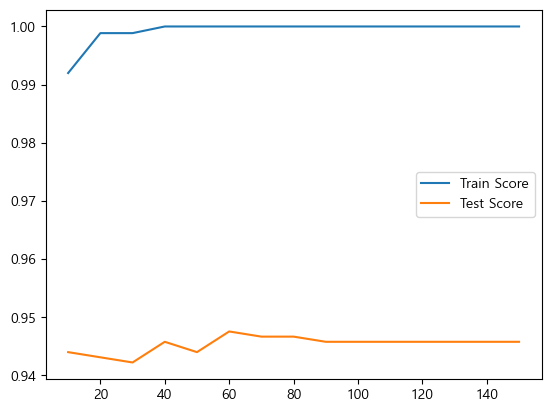

In [27]:
plt.plot(para_n_tree, train_score, linestyle ="-", label = "Train Score")
plt.plot(para_n_tree, test_score, linestyle ="-", label = "Test Score")
plt.legend()

Train 모델의 정확도가 40 이상에서 100%로 과적합이 이루어지며

test 모델에서 변동이 있지만 60까지 증가함. 40 또는 60 선택 가능

### 하지만 트리 수 파라미터 조정단계에서, 정확도 보다는 oob error 변화를 더 중점으로 생각함

oob error : 과대적합을 방지하고 일반화 정도를 판단하는 지표

In [30]:
oob_error=[]

for v_n_estimator in range(1,151):
    rf = RandomForestClassifier(n_estimators=v_n_estimator, oob_score=True,random_state=1234)
    rf.fit(df_train_x,df_train_y)
    oob_error.append(1-rf.oob_score_)

Text(0.5, 0, 'n_estimators')

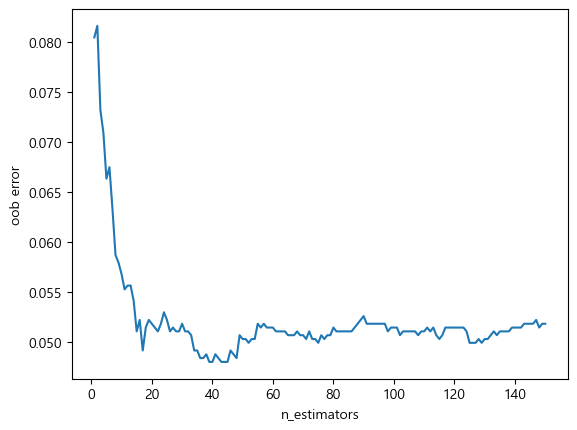

In [31]:
plt.plot(range(1,151),oob_error)
plt.ylabel("oob error")
plt.xlabel("n_estimators")

결정 트리 수 증가에 따라 정확도는 증가하고 OOB ERROR는 감소

모델의 특성을 고려하여 100 선택 (자료가 많은 경우 트리 수를 늘릴 수 있음)

-> 데이터가 4천개 정도인데 트리 수를 늘릴 필요가 있는가?? 이해하기 어려움

In [37]:
train_score = []
test_score = []

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf = RandomForestClassifier(max_depth=v_max_depth, n_estimators = 100, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.908,0.908
1,2,0.912,0.910
2,3,0.932,0.928
3,4,0.933,0.930
4,5,0.938,0.931
5,6,0.941,0.932
6,7,0.945,0.934
7,8,0.949,0.936
8,9,0.951,0.935
9,10,0.956,0.938


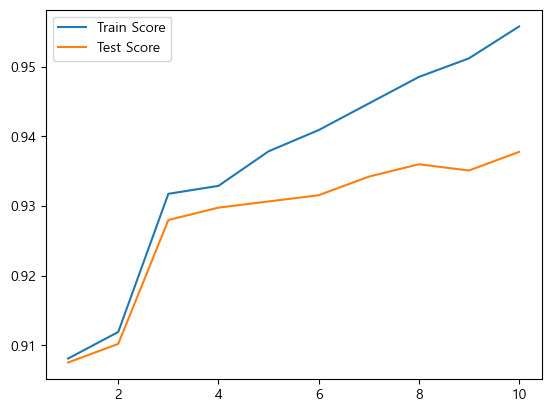

In [38]:
plt.plot(para_depth, train_score, linestyle ="-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle ="-", label = "Test Score")
plt.legend()

In [43]:
train_score = []
test_score = []

para_split = [n_split*10 for n_split in range(1,11)]

for v_min_samples_split in para_split:
    rf = RandomForestClassifier(min_samples_split=v_min_samples_split, n_estimators = 100, max_depth=6, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

df_score_split = pd.DataFrame()
df_score_split["MinSamplesLeaf"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

df_score_split.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,10,0.940,0.931
1,20,0.935,0.931
2,30,0.934,0.931
3,40,0.934,0.931
4,50,0.933,0.931
5,60,0.933,0.931
6,70,0.934,0.931
7,80,0.932,0.929
8,90,0.932,0.929
9,100,0.932,0.929


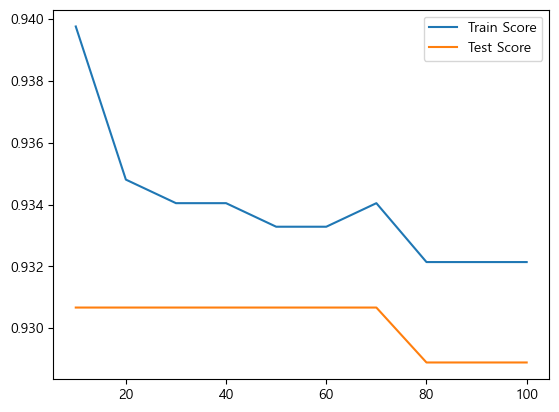

In [44]:
plt.plot(para_split, train_score, linestyle ="-", label = "Train Score")
plt.plot(para_split, test_score, linestyle ="-", label = "Test Score")
plt.legend()

50 이하에서 train 모델의 정확도 변화는 있으나 차이가 거의 없고 test 모델의 정확도 변화가 없어 split을 지정하지 않음

In [45]:
train_score = []
test_score = []

para_leaf = [n_leaf *5 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestClassifier(min_samples_leaf=v_min_samples_leaf,n_estimators = 100,max_depth=6,  random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,5,0.939,0.932
1,10,0.933,0.930
2,15,0.927,0.927
3,20,0.927,0.925
4,25,0.927,0.925
5,30,0.926,0.924
6,35,0.926,0.924
7,40,0.925,0.924
8,45,0.923,0.921
9,50,0.914,0.915


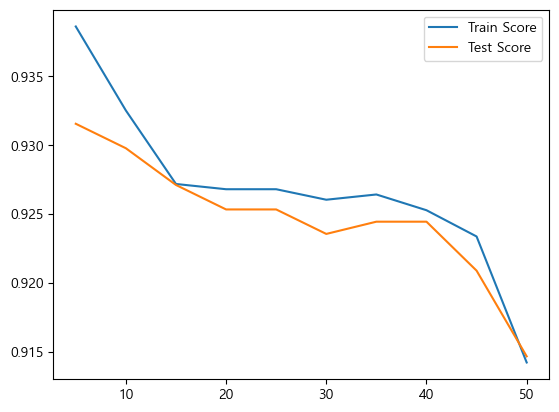

In [46]:
plt.plot(para_leaf, train_score, linestyle ="-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle ="-", label = "Test Score")
plt.legend()

In [56]:
rf_final = RandomForestClassifier( min_samples_leaf=20,max_depth=6, n_estimators = 100,random_state=1234)
rf_final.fit(df_train_x, df_train_y)
y_pred = rf_final.predict(df_test_x)

# 모델 정확도
print("Accuracy on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(rf_final.score(df_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix:\n{}".format(confusion_matrix(df_test_y,df_test_y)))
#목표변수의 빈도 불균형 : f1-score 로 모델평가
print(classification_report(df_test_y,y_pred,digits=3))

Accuracy on training set: 0.927
Accuracy on test set: 0.925
Confusion matrix:
[[1021    0]
 [   0  104]]
              precision    recall  f1-score   support

           0      0.924     1.000     0.960      1021
           1      1.000     0.192     0.323       104

    accuracy                          0.925      1125
   macro avg      0.962     0.596     0.642      1125
weighted avg      0.931     0.925     0.902      1125



"1" 기준 f1-score : 32.3%  (precision 은 100% 이지만 recall 이 매우 낮음)

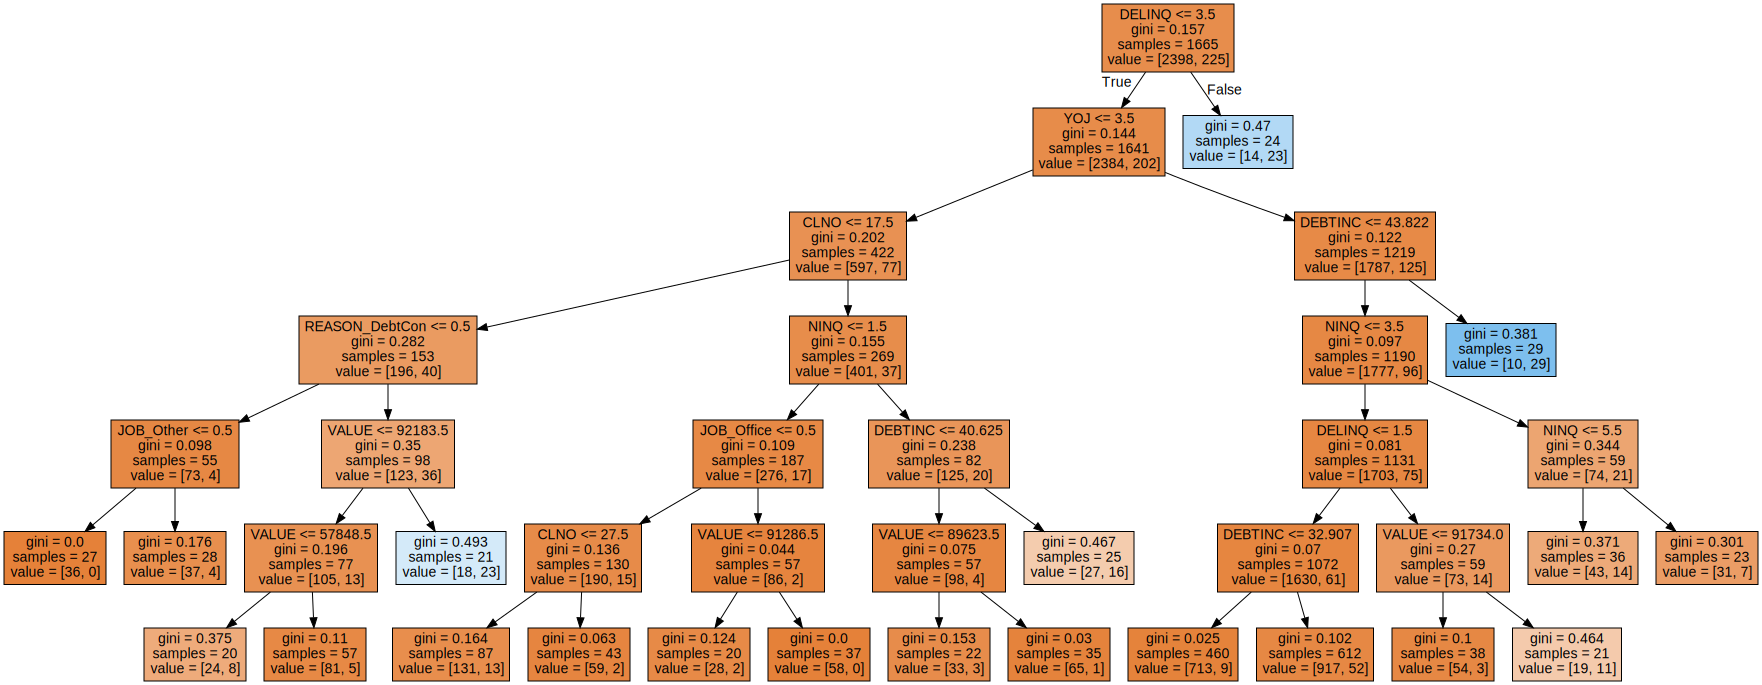

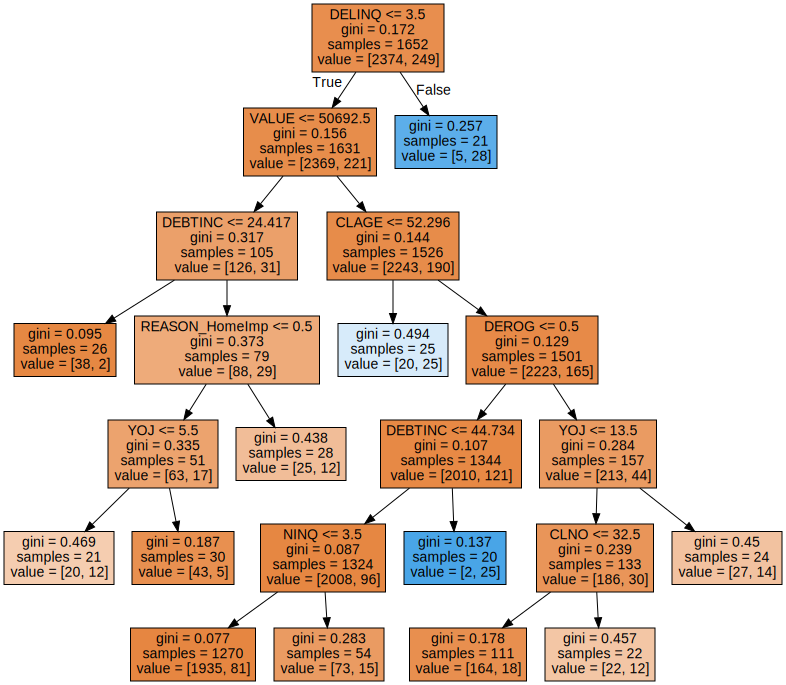

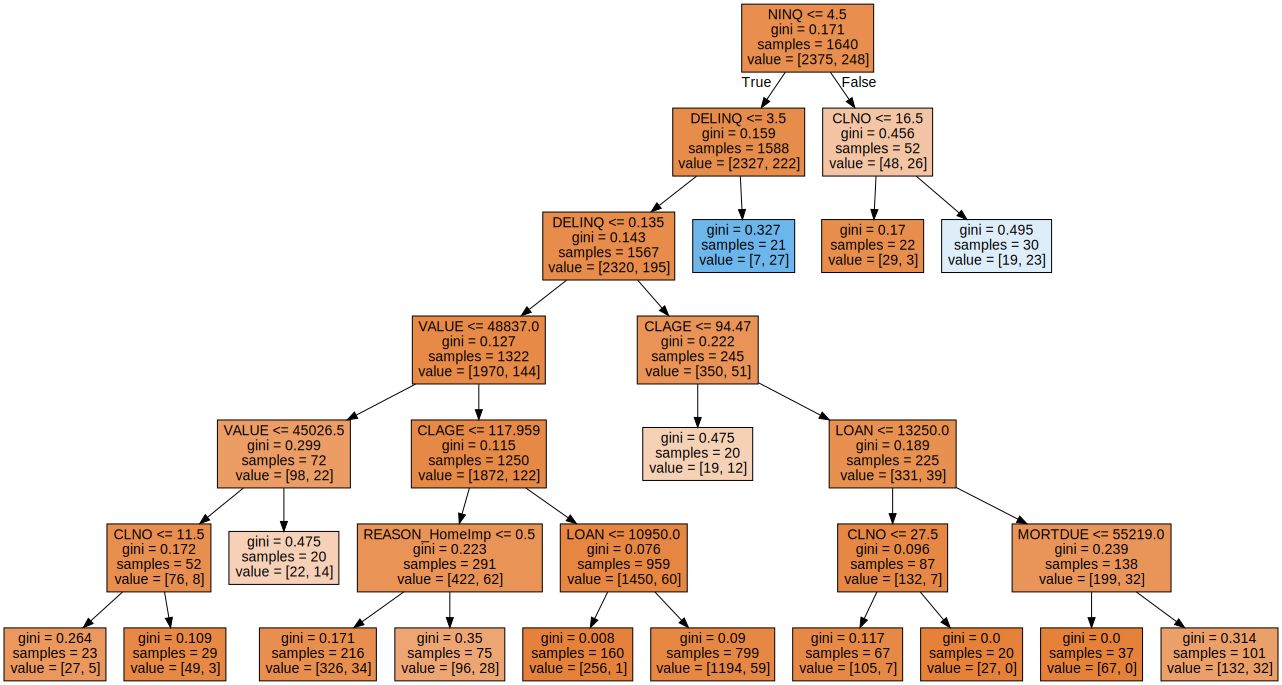

In [48]:
v_feature_name = df_train_x.columns

export_graphviz(rf_final.estimators_[0], out_file="rfr_final_0.dot",
               feature_names=v_feature_name, impurity=True, filled = True)
with open("rfr_final_0.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

export_graphviz(rf_final.estimators_[1], out_file="rfr_final_1.dot",
               feature_names=v_feature_name, impurity=True, filled = True)
with open("rfr_final_1.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

export_graphviz(rf_final.estimators_[10], out_file="rfr_final_10.dot",
               feature_names=v_feature_name, impurity=True, filled = True)
with open("rfr_final_10.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [52]:
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
9,DEBTINC,0.502
5,DELINQ,0.148
6,CLAGE,0.064
4,DEROG,0.058
8,CLNO,0.056
7,NINQ,0.050
0,LOAN,0.036
2,VALUE,0.036
3,YOJ,0.016
1,MORTDUE,0.014


Text(0, 0.5, '변수')

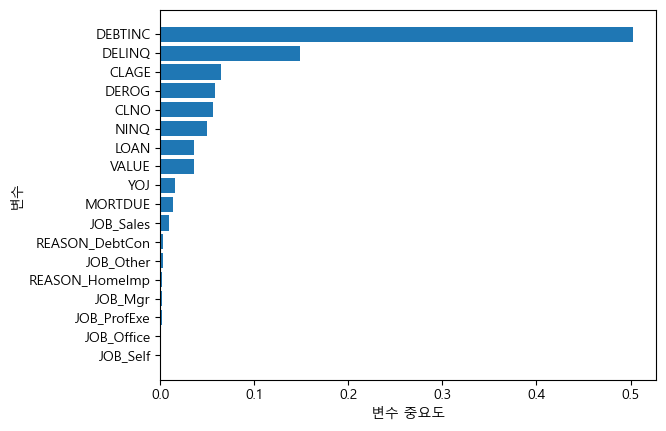

In [53]:
df_importance.sort_values("Importance",ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

In [54]:
estimator = RandomForestClassifier(n_estimators=100,random_state=1234)
param_grid = {"max_depth":para_depth, "min_samples_leaf":para_leaf}

grid_rf = GridSearchCV(estimator, param_grid, scoring = "accuracy", n_jobs=-1)
grid_rf.fit(df_train_x,df_train_y)

print("best estimator model:\n{}".format(grid_rf.best_estimator_))
print("\nbest parameter:\n{}".format(grid_rf.best_params_))
print("\nbest score:\n{}".format(grid_rf.best_score_.round(3)))

best estimator model:
RandomForestClassifier(max_depth=9, min_samples_leaf=5, random_state=1234)

best parameter:
{'max_depth': 9, 'min_samples_leaf': 5}

best score:
0.935
